In [ ]:
"""
If running in colab, mount (download) repo and work from there to be able to use modules and download dataset(s)

PRE-REQUIREMENT:
- create a github personnal access token (finegrained or not) https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/managing-your-personal-access-tokens#creating-a-fine-grained-personal-access-token
- add it as a secret in colab with name GITHUB_ACCESS_TOKEN https://medium.com/@parthdasawant/how-to-use-secrets-in-google-colab-450c38e3ec75
"""
import os
if os.getenv("COLAB_RELEASE_TAG"): # check if running un Google Collab
  if not os.path.isdir('/content/jan24_supply_chain'): # check if repo already exists
    from google.colab import userdata
    GITHUB_ACCESS_TOKEN = userdata.get('GITHUB_ACCESS_TOKEN') # get personnal access token to github
    !git clone --quiet {'https://' + GITHUB_ACCESS_TOKEN + '@github.com/DataScientest-Studio/jan24_supply_chain.git'} # download repo
  os.chdir('/content/jan24_supply_chain/notebooks') # switch the wordking dir to the repo notebook folder (to emulate running locally to use same relative paths)

In [ ]:
import data_loader
data_loader.download_datasets()
data_loader.download_models()

Source folder: https://drive.google.com/open?id=11vDQFcg_DQRGG9FDB0AAJTBipYY4XE11&usp=drive_fs
Downloaded files:
/Users/gwibaux/Workspaces/jan24_supply_chain/data/chatgpt_labelled_reviews_edited.csv
/Users/gwibaux/Workspaces/jan24_supply_chain/data/chatgpt_labelled_reviews.csv
/Users/gwibaux/Workspaces/jan24_supply_chain/data/processed_dataset.csv


# Chargement des données

,review,chatgpt_label,date,company,month
81,vous vous foutez de la gueule du monde Cdiscou...,Problème de remboursement,2022-10-11,CDiscount,2022-10
726,"colis non reçu a la date indiquée, toujours en...",Problème de livraison,2022-07-25,CDiscount,2022-07
293,Quel forcing pour prendre amazon prime... incr...,Problème d'abonnement,2022-09-07,Amazon,2022-09
41,Nous avons commandé une montre pour l'annivers...,Problème avec le produit,2022-09-19,Amazon,2022-09
226,J'arrive déjà pas à comprendre comment Cdiscou...,Problème d'abonnement,2021-12-01,CDiscount,2021-12


train shape:  (800, 5)
test shape:  (200, 5)


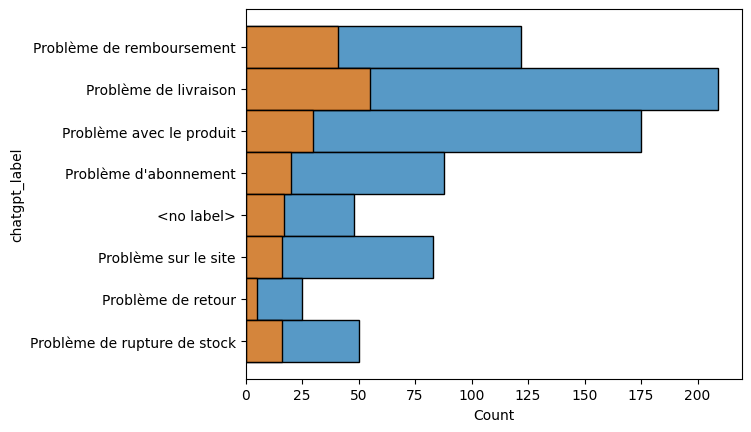

In [51]:
import pandas as pd
from itables import show
import ast
import numpy as np
import seaborn as sns

df = pd.read_csv('../../data/chatgpt_labelled_reviews_1000/train.csv')
df_test = pd.read_csv('../../data/chatgpt_labelled_reviews_1000/test.csv')
df = df.drop(["Unnamed: 0"],axis=1)
df_test = df_test.drop(["Unnamed: 0"],axis=1)

display(df.sample(5))
print('train shape: ', df.shape)
print('test shape: ', df_test.shape)
sns.histplot(y='chatgpt_label', data=df);
sns.histplot(y='chatgpt_label', data=df_test);

On remarque que notre dataset n'est pas très équilibré et que certains problèmes sont très peu représentés.

# SBERT + KNN : implémentation

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util

                              precision    recall  f1-score   support

                  <no label>       1.00      0.06      0.11        17
    Problème avec le produit       0.29      0.23      0.26        30
       Problème d'abonnement       0.24      0.25      0.24        20
       Problème de livraison       0.45      0.56      0.50        55
   Problème de remboursement       0.33      0.32      0.32        41
          Problème de retour       0.00      0.00       nan         5
Problème de rupture de stock       0.27      0.38      0.32        16
        Problème sur le site       0.13      0.12      0.13        16

                    accuracy                           0.33       200
                   macro avg       0.34      0.24      0.27       200
                weighted avg       0.38      0.33      0.32       200



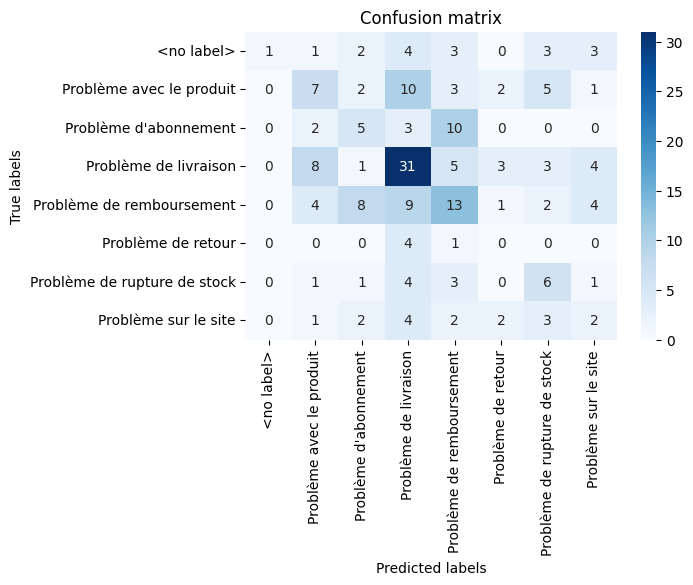

In [23]:
embedder_model = SentenceTransformer('distilbert-multilingual-nli-stsb-quora-ranking')
X_train = embedder_model.encode(df['review'].to_numpy(), convert_to_tensor=False)
X_test = embedder_model.encode(df_test['review'].to_numpy(), convert_to_tensor=False)

target_encoder = LabelEncoder()
y_train = target_encoder.fit_transform(df['chatgpt_label'])
y_test = target_encoder.transform(df_test['chatgpt_label'])


knn = neighbors.KNeighborsClassifier(
    n_neighbors=1, # nb de voisins
    metric='cosine' # distance
)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=np.nan, target_names=list(target_encoder.classes_)))

conf_matrix = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

#target_encoder.inverse_transform(y_test)

Rendons cela plus réutilisable pour pourvoir tester différents hyperparamètres.

In [24]:
class SimilarityKNNClassifierPipeline():
    """
    params
    --
    embedder_model : local path or pretained model name
    corpus : df or array with the classifier reviews
    """
    def __init__(self, embedder_model, n_neighbors=1, weights='uniform'):
        # load model
        self.target_encoder = LabelEncoder()
        self.embedder_model = SentenceTransformer(embedder_model)
        self.knn = neighbors.KNeighborsClassifier(
            n_neighbors=n_neighbors, # nb de voisins
            metric='cosine', # distance
            weights=weights
            )
        
    def fit(self, X_train, y_train):
        
        self.corpus_reviews = X_train.to_numpy() # TODO check indexes
        self.corpus_labels = y_train.to_numpy()

        enc_X_train = self.embedder_model.encode(X_train.to_numpy(), convert_to_tensor=False)

        enc_y_train = self.target_encoder.fit_transform(y_train)

        self.knn.fit(enc_X_train, enc_y_train)


    def predict(self, X):
        # compute query embeddings
        query_embedding = self.embedder_model.encode(X.to_numpy(), convert_to_tensor=False)
        # KNN
        y_pred = self.knn.predict(query_embedding)

        #k_neighbors = util.semantic_search(query_embedding, self.corpus_embeddings, top_k=n_neighbors) # top neighbors according to cos_sim
        # TODO return predicted class if via sbert
        
        return y_pred
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        enc_y_test = self.target_encoder.transform(y_test)
        return accuracy_score(enc_y_test, y_pred)
        
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        enc_y_test = self.target_encoder.transform(y_test)
        
        print(classification_report(enc_y_test, y_pred, zero_division=np.nan, target_names=list(target_encoder.classes_)))

        conf_matrix = confusion_matrix(enc_y_test,y_pred)
        plt.figure(figsize=(6,4))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=self.target_encoder.classes_, yticklabels=self.target_encoder.classes_)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion matrix')
        plt.show()

        sampled_preds = pd.DataFrame()
        sampled_preds['review'] = X_test.to_numpy()
        sampled_preds['true_label'] = y_test.to_numpy()
        sampled_preds['pred_label'] = self.target_encoder.inverse_transform(y_pred)
        display(sampled_preds.sample(5))


In [34]:
X_train, X_test, y_train, y_test = df['review'], df_test['review'], df['chatgpt_label'], df_test['chatgpt_label']

clf = SimilarityKNNClassifierPipeline('distilbert-multilingual-nli-stsb-quora-ranking', n_neighbors=1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.325

# Evaluation des hyper-paramètres du KNN

## k-values and sbert base model

In [35]:
# comparaison d'hyperparams :  k et base model pour calculer les embeddings

score_pre_finetuning = []
score_post_finetuning = []

k_range = range(1,30)
embedder_models = [
    'distilbert-multilingual-nli-stsb-quora-ranking',
    'paraphrase-multilingual-MiniLM-L12-v2',
    ]
scores = []


for embedder_model in embedder_models:
    model_scores = []
    for k in k_range:
        clf = SimilarityKNNClassifierPipeline(embedder_model, n_neighbors=k)
        clf.fit(X_train, y_train)
        model_scores.append(clf.score(X_test, y_test))
    scores.append(model_scores)


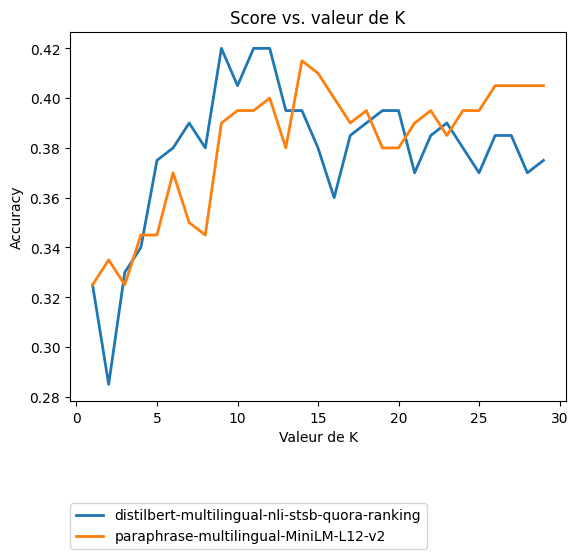

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
for i, embedder_model in enumerate(embedder_models):
    plt.plot(k_range, scores[i], lw=2, label=embedder_model)
#plt.plot(k_range, score_post_finetuning, color='blue', linestyle='dashed', lw=2, label='post fine-tuning')
plt.title('Score vs. valeur de K')  
plt.xlabel('Valeur de K')  
plt.ylabel('Accuracy') 
plt.legend(loc=(0, -0.4));

## Comparing different fine-tuned models : impact of number of pairs

In [123]:
# comparaison d'hyperparams : définir k

score_pre_finetuning = []
score_post_finetuning = []

k_range = range(1,30) #range(1,31,2)
embedder_models = [
    'distilbert-multilingual-nli-stsb-quora-ranking',
    #'paraphrase-multilingual-MiniLM-L12-v2',
    "../models/fine-tuned - train_len=800,  pairs_sample_size=3900 - epochs=10, batch_size=32, base_model=distilbert-multilingual-nli-stsb-quora-ranking",
    "../models/fine-tuned - train_len=800,  pairs_sample_size=13000 - epochs=5, batch_size=32, base_model=distilbert-multilingual-nli-stsb-quora-ranking",
    "../models/fine-tuned - train_len=800,  pairs_sample_size=26000 - epochs=7, batch_size=32, base_model=distilbert-multilingual-nli-stsb-quora-ranking",
    "../models/fine-tuned - train_len=800,  pairs_sample_size=130000 - epochs=7, batch_size=32, base_model=distilbert-multilingual-nli-stsb-quora-ranking"
    ]
scores = []


for embedder_model in embedder_models:
    model_scores = []
    for k in k_range:
        clf = SimilarityKNNClassifierPipeline(embedder_model, n_neighbors=k)
        clf.fit(X_train, y_train)
        model_scores.append(clf.score(X_test, y_test))
    scores.append(model_scores)


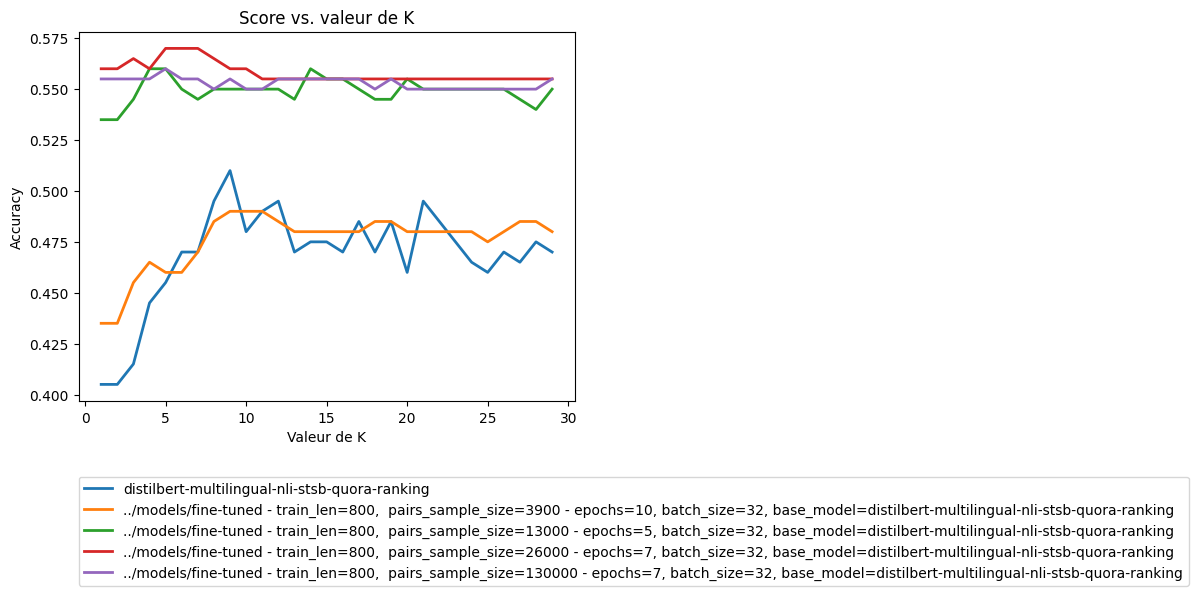

: 

In [125]:
import matplotlib.pyplot as plt
%matplotlib inline
for i, embedder_model in enumerate(embedder_models):
    plt.plot(k_range, scores[i], lw=2, label=embedder_model)
#plt.plot(k_range, score_post_finetuning, color='blue', linestyle='dashed', lw=2, label='post fine-tuning')
plt.title('Score vs. valeur de K')  
plt.xlabel('Valeur de K')  
plt.ylabel('Accuracy') 
plt.legend(loc=(0, -0.5));

                              precision    recall  f1-score   support

                  <no label>       0.77      1.00      0.87        17
    Problème avec le produit       0.54      0.63      0.58        30
       Problème d'abonnement       0.30      0.40      0.34        20
       Problème de livraison       0.62      0.65      0.64        55
   Problème de remboursement       0.65      0.37      0.47        41
          Problème de retour       0.14      0.20      0.17         5
Problème de rupture de stock       0.71      0.62      0.67        16
        Problème sur le site       0.36      0.31      0.33        16

                    accuracy                           0.56       200
                   macro avg       0.51      0.52      0.51       200
                weighted avg       0.57      0.56      0.55       200



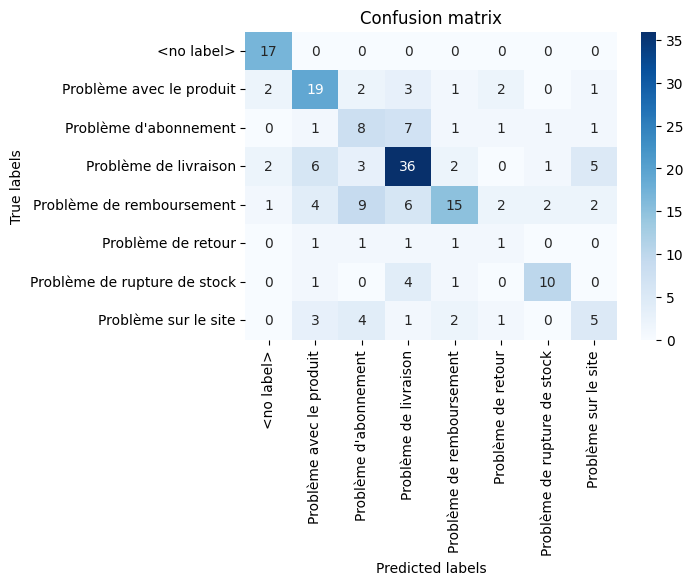

,review,true_label,pred_label
101,J'ai acheté un téléphone à la Fnac. Le vendeur...,Problème d'abonnement,Problème d'abonnement
29,bonjourmoi d habitude quand je commande sur c ...,Problème d'abonnement,Problème d'abonnement
35,escro voleur bref il ne faut surtout pas achet...,Problème avec le produit,Problème d'abonnement
58,J’en déconseille ce site ! J’ai achetée un iPh...,Problème avec le produit,Problème avec le produit
172,<no label>,<no label>,<no label>


In [ ]:
clf =  SimilarityKNNClassifierPipeline("../models/fine-tuned - train_len=800,  pairs_sample_size=130000 - epochs=7, batch_size=32, base_model=distilbert-multilingual-nli-stsb-quora-ranking", n_neighbors=1)
clf.fit(X_train, y_train)
clf.evaluate(X_test, y_test)